In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
from neurodsp.filt import filter_signal
from scipy.spatial import cKDTree

sns.set(style='white', context='notebook')

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

In [2]:
path_to_hpc = r"C:\Users\ejsev\Downloads\sleep scoring\post_trial2_2017-09-21_11-57-34\HPC_100_CH46.continuous.mat"
path_to_states = r"C:\Users\ejsev\Downloads\sleep scoring\post_trial2_2017-09-21_11-57-34\post_trial2_2017-09-21_11-57-34-states.mat"

config = emd.sift.SiftConfig.from_yaml_file(r"C:\Users\ejsev\Downloads\sleep scoring\emd_masksift_CA1_config_2500.yml")

There was 0 in the dataset


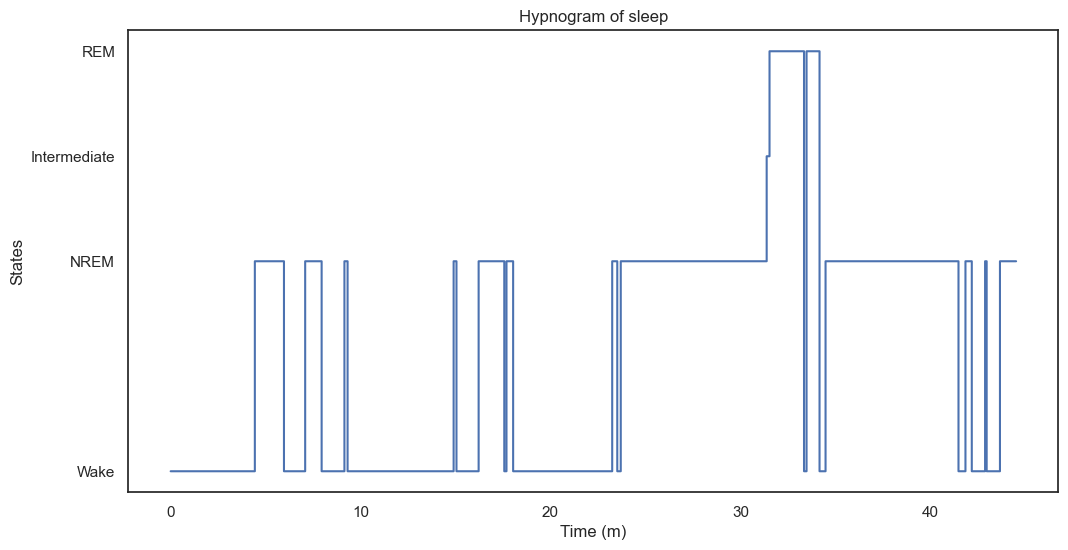

In [3]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)
plot_hypnogram(hypno)

In [4]:
np.unique(hypno)

array([1, 3, 4, 5], dtype=uint8)

In [5]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [6]:
t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

len(phasic_interval)

Number of detected Tonic intrevals:6
Number of detected Tonic intrevals after threshold:6


4

In [7]:
print([phasic_interval])

[  index    start      end
      0  1912.93  1914.05
      1  1937.51  1941.3
      2  1955.13  1956.12
      3  2014.55  2015.7
shape: (4, 2), time unit: sec.]


In [8]:
print([tonic_interval])

[  index    start      end
      0  1893     1912.93
      1  1914.05  1937.51
      2  1941.3   1955.13
      3  1956.12  2001
      4  2010     2014.55
      5  2015.7   2050
shape: (6, 2), time unit: sec.]


In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

[4782335]
[4785115]


Text(0.5, 1.0, 'phasic HPC signal')

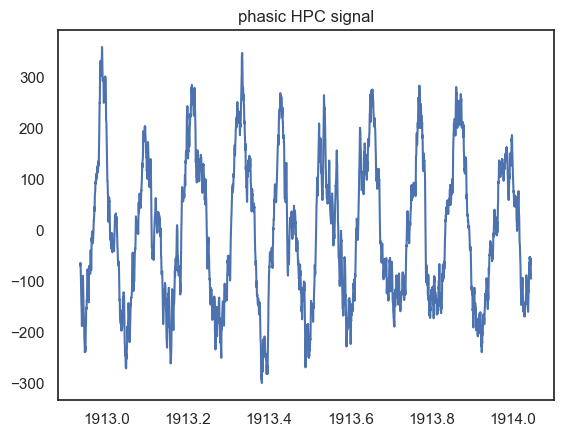

In [10]:
interval_low = find_nearest(t, phasic_interval[0,0])
index_low = np.where(t == interval_low)[0]
print(index_low)

interval_high = find_nearest(t, phasic_interval[0,1])
index_high = np.where(t == interval_high)[0]
print(index_high)
plt.plot(t[index_low[0]:index_high[0]], lfpHPC[index_low[0]:index_high[0]])
plt.title('phasic HPC signal')

In [12]:
def get_data2(lfp_path, state_path):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    lfp = np.squeeze(data['PFC'])
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs

In [13]:
path_to_pfc = r"C:\Users\ejsev\Downloads\sleep scoring\post_trial2_2017-09-21_11-57-34\PFC_100_CH11.continuous.mat"
path_to_states = r"C:\Users\ejsev\Downloads\sleep scoring\post_trial2_2017-09-21_11-57-34\post_trial2_2017-09-21_11-57-34-states.mat"

config = emd.sift.SiftConfig.from_yaml_file(r"C:\Users\ejsev\Downloads\sleep scoring\emd_masksift_CA1_config_2500.yml")

lfpPFC, hypno_pfc, fs = get_data2(path_to_pfc, path_to_states)

There was 0 in the dataset


## Comparison

In [15]:
def extract_pt_intervals_pfc(lfpPFC, hypno_pfc, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno_pfc, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpPFC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpPFC, columns=['PFC'])
    #will be deleted later, only the lfp is used

    # Detect phasic intervals
    lfpPFC_down = preprocess(lfpPFC, n_down)
    phREM = detect_phasic(lfpPFC_down, hypno_pfc, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [16]:
t2 = np.arange(0, len(lfpPFC) / fs, 1 / fs)
phasic_interval2, tonic_interval2, lfp2 = extract_pt_intervals(lfpPFC, hypno_pfc) #only lfp2 will be used

Number of detected Tonic intrevals:4
Number of detected Tonic intrevals after threshold:4


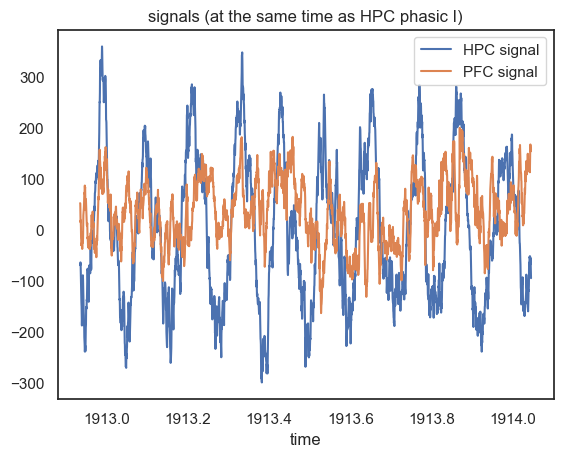

In [18]:
plt.plot(t[index_low[0]:index_high[0]], lfp[index_low[0]:index_high[0]], label = 'HPC signal')
plt.plot(t[index_low[0]:index_high[0]], lfp2[index_low[0]:index_high[0]], label = 'PFC signal')
plt.title('signals (at the same time as HPC phasic I)')
plt.xlabel('time')
plt.legend()

In [19]:
signal1 = (lfpHPC[index_low[0]:index_high[0]]).T
signal2 = (lfpPFC[index_low[0]:index_high[0]]).T

signal = np.vstack((signal1.T,signal2.T)).T
signal.shape

time = t[index_low[0]:index_high[0]]

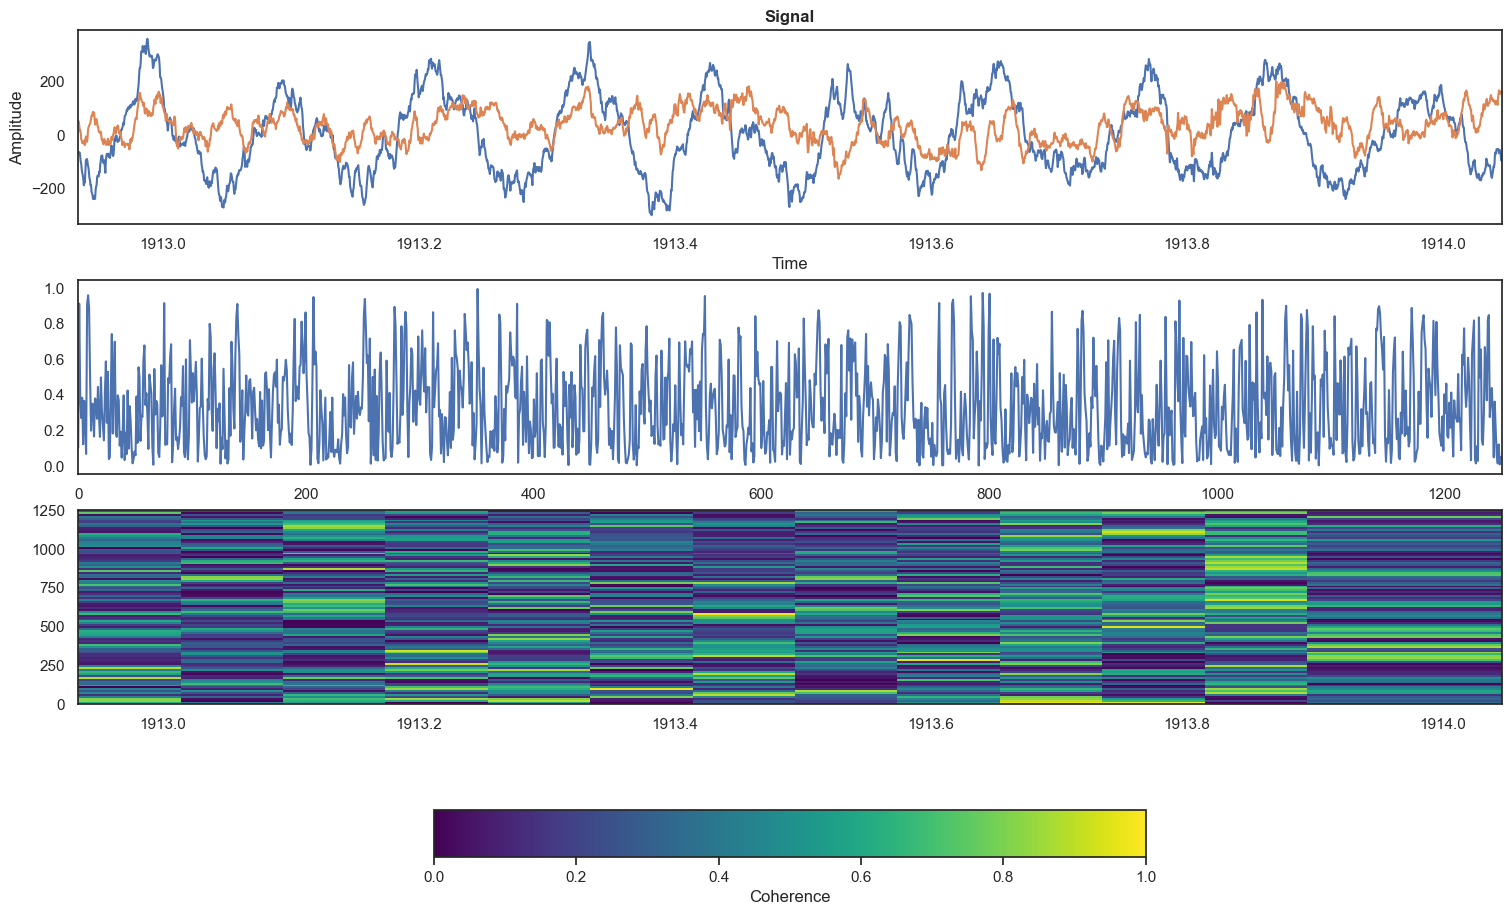

In [20]:
time_halfbandwidth_product = 2 #test value from example
frequency_of_interest = 200 #test value from example
sampling_frequency = 2500
time_extent = (t[index_low[0]], t[index_high[0]])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 9), constrained_layout=True)
axes[0].set_title("Signal", fontweight="bold")
axes[0].plot(time, signal[:, 0], label="Signal1")
axes[0].plot(time, signal[:, 1], label="Signal2")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlim(time_extent)

multitaper = Multitaper(
    signal,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)
axes[1].plot(
    connectivity.frequencies, connectivity.coherence_magnitude()[..., 0, 1].squeeze()
)
axes[1].set_xlim((0, multitaper.nyquist_frequency))

multitaper = Multitaper(
    signal,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    time_window_duration=0.080,
    time_window_step=0.080,
    start_time=time[0],
)
connectivity = Connectivity.from_multitaper(multitaper)

time_grid, freq_grid = np.meshgrid(
    np.append(connectivity.time, time_extent[-1]),
    np.append(connectivity.frequencies, multitaper.nyquist_frequency),
)

mesh = axes[2].pcolormesh(
    time_grid,
    freq_grid,
    connectivity.coherence_magnitude()[..., 0, 1].squeeze().T,
    vmin=0.0,
    vmax=1.0,
    cmap="viridis",
)

cb = fig.colorbar(
    mesh,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    shrink=0.5,
    aspect=15,
    pad=0.1,
    label="Coherence",
)